In [1]:
# ============================
# 1. IMPORTS & CONFIG
# ============================
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt

# GA hyperparameters
POP_SIZE = 50
NUM_GENERATIONS = 120
TOURNAMENT_SIZE = 4
CROSSOVER_RATE = 0.9
MUTATION_RATE = 0.2
LACK_IMPROVEMENT_LIMIT = 25

# Nurse load penalty
NURSE_PENALTY_WEIGHT = 1.5

random.seed(42)
np.random.seed(42)


In [2]:
# ============================
# 2. LOAD TRAIN DATASET
# ============================

patients_df = pd.read_csv("patient_dataset.csv")
beds_df = pd.read_csv("bed_dataset.csv")

patients = patients_df.to_dict(orient="records")
beds = beds_df.to_dict(orient="records")

NUM_PATIENTS = len(patients)
NUM_BEDS = len(beds)
NUM_NURSE_GROUPS = beds_df["nurse_group"].nunique()
IDEAL_LOAD = NUM_BEDS / NUM_NURSE_GROUPS


In [3]:
# ============================
# 3. PRIORITY SCORE FUNCTIONS
# ============================

def age_factor(age):
    return 0.5 if age < 40 else 0.8 if age < 60 else 1.0

def comorbidity_factor(c):
    return 0.5 + 0.1 * c

def compute_patient_priority(p):
    score = (0.35 * p["risk_level"] +
             0.30 * p["vital_severity"] +
             0.20 * p["recommendation"] +
             0.10 * age_factor(p["age"]) * 10 +
             0.05 * comorbidity_factor(p["comorbidities"]) * 10)
    return score

patient_priority = [compute_patient_priority(p) for p in patients]


In [4]:
# ============================
# 4. CHROMOSOME + MATCH SCORE
# ============================

def create_chromosome():
    return random.sample(range(NUM_PATIENTS), NUM_BEDS)

def bed_match_score(patient_id, bed_id):
    bed = beds[bed_id]
    p = patients[patient_id]

    score = bed["specialty_match"]
    if bed["ventilator"] == 1 and p["risk_level"] >= 7:
        score += 0.5
    if p["vital_severity"] >= 8:
        score += 0.3
    return score


In [5]:
# ============================
# 5. FITNESS FUNCTION
# ============================

def fitness(chromosome):
    survival = 0
    loads = [0] * NUM_NURSE_GROUPS

    for bed_id, patient_id in enumerate(chromosome):
        survival += patient_priority[patient_id] * bed_match_score(patient_id, bed_id)
        loads[beds[bed_id]["nurse_group"]] += 1

    imbalance = sum((load - IDEAL_LOAD)**2 for load in loads)
    penalty = NURSE_PENALTY_WEIGHT * imbalance
    total = survival - penalty

    return total, survival, loads


In [6]:
# ============================
# 6. GA OPERATORS
# ============================

def tournament_selection(pop, fits):
    best = None
    for _ in range(TOURNAMENT_SIZE):
        idx = random.randint(0, len(pop) - 1)
        if best is None or fits[idx][0] > fits[best][0]:
            best = idx
    return pop[best][:]

def repair(chrom):
    seen = set()
    dup = []
    for i, gene in enumerate(chrom):
        if gene in seen:
            dup.append(i)
        else:
            seen.add(gene)

    missing = [p for p in range(NUM_PATIENTS) if p not in seen]
    random.shuffle(missing)

    for i in dup:
        chrom[i] = missing.pop()
    return chrom

def crossover(p1, p2):
    if random.random() > CROSSOVER_RATE:
        return p1[:], p2[:]

    a = random.randint(0, NUM_BEDS - 2)
    b = random.randint(a + 1, NUM_BEDS - 1)

    c1 = repair(p1[:a] + p2[a:b] + p1[b:])
    c2 = repair(p2[:a] + p1[a:b] + p2[b:])
    return c1, c2

def mutate(chrom):
    if random.random() < MUTATION_RATE:
        i, j = random.sample(range(NUM_BEDS), 2)
        chrom[i], chrom[j] = chrom[j], chrom[i]
    return chrom


In [7]:
# ============================
# 7. GA TRAINING LOOP
# ============================

population = [create_chromosome() for _ in range(POP_SIZE)]

best_chrom = None
best_fit = -999999
best_details = None
no_improve = 0

for gen in range(NUM_GENERATIONS):
    fits = [fitness(ch) for ch in population]

    gen_best = max(fits, key=lambda x: x[0])
    idx = fits.index(gen_best)

    if gen_best[0] > best_fit:
        best_fit = gen_best[0]
        best_chrom = population[idx][:]
        best_details = gen_best
        no_improve = 0
    else:
        no_improve += 1

    if (gen + 1) % 20 == 0:
        print(f"Generation {gen+1} | Best Fitness: {best_fit:.2f}")

    if no_improve >= LACK_IMPROVEMENT_LIMIT:
        print("\nEarly stopping: No improvement.")
        break

    # Elitism
    sorted_idx = sorted(range(len(population)), key=lambda x: fits[x][0], reverse=True)
    new_pop = [population[sorted_idx[0]][:], population[sorted_idx[1]][:]]

    while len(new_pop) < POP_SIZE:
        p1 = tournament_selection(population, fits)
        p2 = tournament_selection(population, fits)
        c1, c2 = crossover(p1, p2)
        new_pop.append(mutate(c1))
        if len(new_pop) < POP_SIZE:
            new_pop.append(mutate(c2))

    population = new_pop


Generation 20 | Best Fitness: 312.24
Generation 40 | Best Fitness: 339.26
Generation 60 | Best Fitness: 346.14
Generation 80 | Best Fitness: 350.76
Generation 100 | Best Fitness: 354.64
Generation 120 | Best Fitness: 358.63


In [31]:
print("\n======== TRAINING RESULT ========")
print("Best Fitness:", best_fit)
print("Survival Score:", best_details[1])
print("Nurse Loads (Beds per Nurse Group):", best_details[2])

print("\n---- ICU Bed Assignment (TRAINING) ----")
print("Format: BedID (Ventilator, NurseGroup) -> PatientID | Risk, Vital, Rec, Priority")

for bed_id, patient_id in enumerate(best_chrom):
    p = patients[patient_id]
    b = beds[bed_id]
    prio = patient_priority[patient_id]

    print(f"Bed {bed_id:02d} (V={b['ventilator']}, NG={b['nurse_group']}) "
          f"-> Patient {patient_id:03d} | "
          f"Risk={p['risk_level']} Vital={p['vital_severity']} Rec={p['recommendation']} "
          f"Prio={prio:.2f}")



======== TRAINING RESULT ========
Best Fitness: 358.627
Survival Score: 361.627
Nurse Loads (Beds per Nurse Group): [10, 9, 10, 11]

---- ICU Bed Assignment (TRAINING) ----
Format: BedID (Ventilator, NurseGroup) -> PatientID | Risk, Vital, Rec, Priority
Bed 00 (V=0, NG=3) -> Patient 097 | Risk=5 Vital=9 Rec=7 Prio=6.65
Bed 01 (V=0, NG=3) -> Patient 033 | Risk=4 Vital=10 Rec=8 Prio=6.75
Bed 02 (V=1, NG=0) -> Patient 143 | Risk=10 Vital=9 Rec=7 Prio=9.00
Bed 03 (V=1, NG=1) -> Patient 091 | Risk=7 Vital=10 Rec=7 Prio=8.10
Bed 04 (V=1, NG=2) -> Patient 110 | Risk=8 Vital=9 Rec=6 Prio=8.15
Bed 05 (V=1, NG=2) -> Patient 062 | Risk=7 Vital=10 Rec=6 Prio=8.10
Bed 06 (V=1, NG=2) -> Patient 090 | Risk=10 Vital=7 Rec=6 Prio=8.30
Bed 07 (V=1, NG=2) -> Patient 100 | Risk=7 Vital=10 Rec=8 Prio=8.25
Bed 08 (V=1, NG=0) -> Patient 088 | Risk=7 Vital=9 Rec=2 Prio=6.80
Bed 09 (V=0, NG=1) -> Patient 015 | Risk=3 Vital=8 Rec=9 Prio=6.60
Bed 10 (V=0, NG=3) -> Patient 019 | Risk=7 Vital=8 Rec=3 Prio=6.30
Be

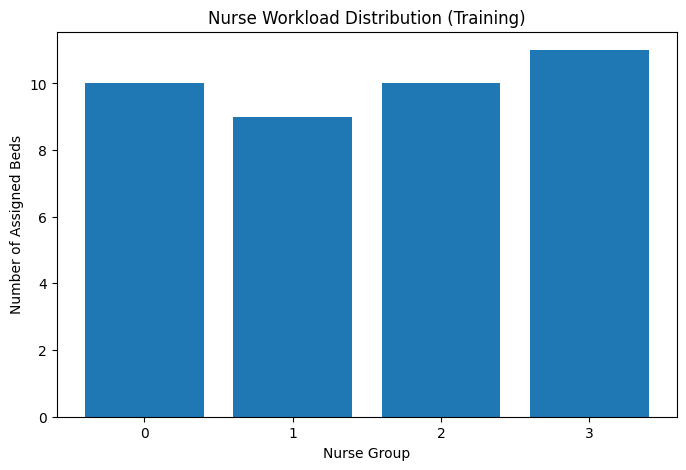

In [33]:
import matplotlib.pyplot as plt

loads = best_details[2]   # from training GA

plt.figure(figsize=(8,5))
plt.bar(range(NUM_NURSE_GROUPS), loads, tick_label=[0,1,2,3])
plt.xlabel("Nurse Group")
plt.ylabel("Number of Assigned Beds")
plt.title("Nurse Workload Distribution (Training)")
plt.show()


In [23]:
import pandas as pd
import random
import numpy as np

# Load bed dataset
beds_df = pd.read_csv("bed_dataset.csv")
beds = beds_df.to_dict(orient="records")

NUM_BEDS = len(beds)
NUM_NURSE_GROUPS = beds_df["nurse_group"].nunique()
IDEAL_LOAD = NUM_BEDS / NUM_NURSE_GROUPS

# Load TEST dataset
test_df = pd.read_csv("new_patients_test.csv")
test_patients = test_df.to_dict(orient="records")

print("Test dataset size:", len(test_patients))


Test dataset size: 40


In [24]:
def age_factor(age):
    return 0.5 if age < 40 else 0.8 if age < 60 else 1.0

def comorbidity_factor(c):
    return 0.5 + 0.1 * c

def compute_priority(p):
    score = (0.35 * p["risk_level"] +
             0.30 * p["vital_severity"] +
             0.20 * p["recommendation"] +
             0.10 * age_factor(p["age"]) * 10 +
             0.05 * comorbidity_factor(p["comorbidities"]) * 10)
    return score

test_priority = [compute_priority(p) for p in test_patients]
TEST_N = len(test_patients)


In [25]:
def bed_match_score(patient_id, bed_id):
    bed = beds[bed_id]
    p = test_patients[patient_id]

    score = bed["specialty_match"]
    if bed["ventilator"] == 1 and p["risk_level"] >= 7:
        score += 0.5
    if p["vital_severity"] >= 8:
        score += 0.3

    return score


In [26]:
POP_SIZE = 50
TOURNAMENT_SIZE = 4
CROSSOVER_RATE = 0.9
MUTATION_RATE = 0.2
NURSE_PENALTY_WEIGHT = 1.5

def tournament_selection(pop, fits):
    best = None
    for _ in range(TOURNAMENT_SIZE):
        idx = random.randint(0, len(pop)-1)
        if best is None or fits[idx][0] > fits[best][0]:
            best = idx
    return pop[best][:]

def repair(chrom, TEST_N):
    return [g % TEST_N for g in chrom]  # safe

def crossover(p1, p2, TEST_N):
    if random.random() > CROSSOVER_RATE:
        return repair(p1, TEST_N), repair(p2, TEST_N)
    a, b = sorted(random.sample(range(NUM_BEDS), 2))
    c1 = repair(p1[:a] + p2[a:b] + p1[b:], TEST_N)
    c2 = repair(p2[:a] + p1[a:b] + p2[b:], TEST_N)
    return c1, c2

def mutate(chrom, TEST_N):
    if random.random() < MUTATION_RATE:
        i, j = random.sample(range(NUM_BEDS), 2)
        chrom[i], chrom[j] = chrom[j], chrom[i]
    return repair(chrom, TEST_N)


In [27]:
def test_assign():
    population = [random.sample(range(TEST_N), NUM_BEDS) for _ in range(POP_SIZE)]

    best_fit = float("-inf")
    best_chrom = None
    best_info = None
    stagnation = 0

    for gen in range(60):

        fits = []
        for chrom in population:
            survival = 0
            loads = [0] * NUM_NURSE_GROUPS

            for bed_id, p_id in enumerate(chrom):
                p_id = p_id % TEST_N  # safety
                pr = test_priority[p_id]
                match = bed_match_score(p_id, bed_id)

                survival += pr * match
                loads[beds[bed_id]["nurse_group"]] += 1

            imbalance = sum((l - IDEAL_LOAD)**2 for l in loads)
            fitness_score = survival - NURSE_PENALTY_WEIGHT * imbalance

            fits.append((fitness_score, survival, loads))

        gen_best = max(fits, key=lambda x: x[0])
        idx = fits.index(gen_best)

        if gen_best[0] > best_fit:
            best_fit = gen_best[0]
            best_chrom = population[idx][:]
            best_info = gen_best
            stagnation = 0
        else:
            stagnation += 1

        if stagnation >= 15:
            print("Early stop in testing.")
            break

        # Next generation
        sorted_idx = sorted(range(len(population)), key=lambda i: fits[i][0], reverse=True)
        new_pop = [population[sorted_idx[0]][:], population[sorted_idx[1]][:]]

        while len(new_pop) < POP_SIZE:
            p1 = tournament_selection(population, fits)
            p2 = tournament_selection(population, fits)
            c1, c2 = crossover(p1, p2, TEST_N)
            new_pop.append(mutate(c1, TEST_N))
            if len(new_pop) < POP_SIZE:
                new_pop.append(mutate(c2, TEST_N))

        population = new_pop

    return best_fit, best_chrom, best_info


In [28]:
best_test_fit, best_test_sol, best_test_info = test_assign()


In [34]:
print("\n======== TESTING RESULT ========")
print("Best Fitness:", best_test_fit)
print("Survival Score:", best_test_info[1])
print("Nurse Loads (Beds per Nurse Group):", best_test_info[2])

print("\n---- ICU Bed Assignment (TESTING) ----")
print("Format: BedID (Ventilator, NurseGroup) -> TestPatientID | Risk, Vital, Rec, Priority")

for bed_id, p_id in enumerate(best_test_sol):
    p = test_patients[p_id]
    b = beds[bed_id]
    prio = test_priority[p_id]

    print(f"Bed {bed_id:02d} (V={b['ventilator']}, NG={b['nurse_group']}) "
          f"-> TestPatient {p_id:03d} | "
          f"Risk={p['risk_level']} Vital={p['vital_severity']} Rec={p['recommendation']} "
          f"Prio={prio:.2f}")



======== TESTING RESULT ========
Best Fitness: 419.5125
Survival Score: 422.5125
Nurse Loads (Beds per Nurse Group): [10, 9, 10, 11]

---- ICU Bed Assignment (TESTING) ----
Format: BedID (Ventilator, NurseGroup) -> TestPatientID | Risk, Vital, Rec, Priority
Bed 00 (V=0, NG=3) -> TestPatient 030 | Risk=10 Vital=8 Rec=8 Prio=8.80
Bed 01 (V=0, NG=3) -> TestPatient 024 | Risk=10 Vital=8 Rec=8 Prio=8.30
Bed 02 (V=1, NG=0) -> TestPatient 030 | Risk=10 Vital=8 Rec=8 Prio=8.80
Bed 03 (V=1, NG=1) -> TestPatient 025 | Risk=8 Vital=7 Rec=9 Prio=7.60
Bed 04 (V=1, NG=2) -> TestPatient 030 | Risk=10 Vital=8 Rec=8 Prio=8.80
Bed 05 (V=1, NG=2) -> TestPatient 030 | Risk=10 Vital=8 Rec=8 Prio=8.80
Bed 06 (V=1, NG=2) -> TestPatient 030 | Risk=10 Vital=8 Rec=8 Prio=8.80
Bed 07 (V=1, NG=2) -> TestPatient 024 | Risk=10 Vital=8 Rec=8 Prio=8.30
Bed 08 (V=1, NG=0) -> TestPatient 030 | Risk=10 Vital=8 Rec=8 Prio=8.80
Bed 09 (V=0, NG=1) -> TestPatient 037 | Risk=3 Vital=8 Rec=10 Prio=6.30
Bed 10 (V=0, NG=3) -> 

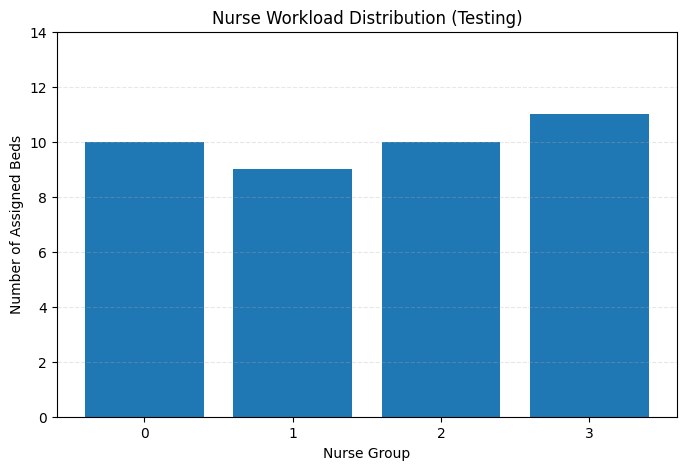

In [35]:
import matplotlib.pyplot as plt

test_loads = best_test_info[2]   # loads from test GA result

plt.figure(figsize=(8,5))
plt.bar(range(NUM_NURSE_GROUPS), test_loads, tick_label=[0, 1, 2, 3])
plt.xlabel("Nurse Group")
plt.ylabel("Number of Assigned Beds")
plt.title("Nurse Workload Distribution (Testing)")
plt.ylim(0, max(test_loads) + 3)   # just makes chart look cleaner
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()
